# Neurog Internship: (Task 9 - Implementation Of Transaction Fees & Initial Balance During Backtesting In Order To Mimic A Real Life Scenario Of Trading. Also Changing The Logic Of The Backtesting To Make It Faster!)

## All Libraries

In [1]:
# For Vizualization & Plotting
import matplotlib.pyplot as plt

# Other Necessary Libraries
import pandas as pd
import numpy as np
import copy

## All Declarations

In [ ]:
# Define the relative path to the CSV file
csv_filename = "BTCUSDT_1_Minute_From_2020_Till_Now.csv"

# Settig Up The Directory From The Directory Hierarchy
# Get the notebook's current directory
notebook_dir = os.path.dirname(os.path.abspath(__file__))

# Go up one level to the parent directory
parent_dir = os.path.dirname(script_dir)

# Create the full path to the output CSV file in the 'ohlc' directory within 'data'
data_dir = os.path.join(parent_dir, "data")
ohlc_dir = os.path.join(data_dir, "ohlc")
full_csv_path = os.path.join(ohlc_dir, csv_filename)

## (Function To Convert DF To Any Timeframe) - Taken From The Previous Day

In [2]:
# Functions converts the dataframe into any given time frame.
def convert_1m_to_any_timeframe(df: pd.DataFrame, timeframe: str) -> pd.DataFrame:
    """
    Convert a DataFrame of 1-minute OHLC data to any given timeframe.

    Args:
    - df (pd.DataFrame): DataFrame containing 1-minute OHLC data. 
      The DataFrame should have a datetime index & columns ['Open', 'High', 'Low', 'Close', 'Volume'].
    - timeframe (str): The desired timeframe to resample the data to (e.g., '1H' for 1 hour, '1D' for 1 day).

    Returns:
    - pd.DataFrame: Resampled DataFrame with OHLC data in the specified timeframe. The index will be renamed to
      reflect the new timeframe.

    Example:
    ```
    resampled_df = convert_1m_to_any_timeframe(ohlc_df, '1H')
    ```
    """
    # Ensure the DataFrame index is of datetime type
    df.index = pd.to_datetime(df.index)
    
    # Try resampling the data to the desired timeframe
    try:
        df_resampled = df.resample(timeframe).agg({
            'Open': 'first',  # Take the first 'Open' value in the timeframe
            'High': 'max',    # Take the maximum 'High' value in the timeframe
            'Low': 'min',     # Take the minimum 'Low' value in the timeframe
            'Close': 'last',  # Take the last 'Close' value in the timeframe
            'Volume': 'mean'  # Take the mean 'Volume' value in the timeframe
        })
    except Exception as e:
        print(f"An error occurred while resampling! Error message: {e}")
        return pd.DataFrame()  # Return an empty DataFrame in case of error

    # Rename the index to reflect the new timeframe
    df_resampled.index.rename(f'Open time ({timeframe})', inplace = True)
    
    return df_resampled

## MACD Indicator Function

In [3]:
def calculate_macd(df: pd.DataFrame, short_window: int = 12, long_window: int = 26, signal_window: int = 9) -> pd.DataFrame:
    """
    Calculate the MACD (Moving Average Convergence Divergence) for a given DataFrame.

    Args:
    - df (pd.DataFrame): DataFrame containing 'Close' price data.
    - short_window (int): The window size for the short-term EMA, default is 12.
    - long_window (int): The window size for the long-term EMA, default is 26.
    - signal_window (int): The window size for the Signal line, default is 9.

    Returns:
    - pd.DataFrame: DataFrame with the MACD line and Signal line.
    """
    # Calculate the short-term and long-term EMAs
    df['EMA_12'] = df['Close'].ewm(span=short_window, adjust=False).mean()
    df['EMA_26'] = df['Close'].ewm(span=long_window, adjust=False).mean()

    # Calculate the MACD line
    df['MACD'] = df['EMA_12'] - df['EMA_26']

    # Calculate the Signal line
    df['Signal_Line'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()

    return df

def generate_macd_signals(df: pd.DataFrame) -> pd.DataFrame:
    """
    Generate trading signals based on MACD values.

    Args:
    - df (pd.DataFrame): DataFrame containing 'MACD' and 'Signal_Line' values.

    Returns:
    - pd.DataFrame: DataFrame with trading signals.
    """
    df['Signal'] = 0  # Default no signal
    df.loc[df['MACD'] > df['Signal_Line'], 'Signal'] = 1  # Buy signal
    df.loc[df['MACD'] < df['Signal_Line'], 'Signal'] = -1  # Sell signal

    return df

## Efficient Backtesting Function

In [4]:
def generate_backtest_df(data, data_1m, initial_balance=1000, transaction_fee=0.01):
    """
    Generate a backtesting DataFrame based on MACD signals.

    Args:
        data (pd.DataFrame): DataFrame containing historical data with columns:
                             'Open time (4H)', 'Open', 'High', 'Low', 'Close', 'Volume', 'MACD_Signal'.
                             The DataFrame must have 'Open time (4H)' as a DateTime index.
        data_1m (pd.DataFrame): DataFrame containing 1-minute interval data with 'Open' prices.
        initial_balance (float): Initial balance for the backtest.
        transaction_fee (float): Transaction fee as a percentage of the current balance for each trade.

    Returns:
        pd.DataFrame: A DataFrame containing the backtesting results with columns:
                      'Open time (4H)', 'direction', 'entry price', 'close price', 'PNL', 'Balance'.
    """
    # For index name
    index_name = data.index.name

    # Extract necessary columns as numpy arrays
    open_prices_1m = data_1m['Open']
    open_prices = data['Open']
    signals = data['Signal'].values
    index_values = data.index.values

    # Determine trade entry points
    signal_changes = np.diff(signals, prepend=signals[0])
    entry_indices = np.where(signal_changes != 0)[0]
    
    # Initialize the exit indices for tp or sl hit (takes the lowest: which happened first)
    exit_index_tp = None
    exit_index_sl = None
    
    # Initialize the backtest results array
    backtest_data = []

    # Initialize trade parameters
    tp = 0.05  # 5% take profit
    sl = 0.03  # 3% stop loss
    
    # Initialize the balance
    balance = initial_balance
    
    for i in range(len(entry_indices)):
        if i == len(entry_indices) - 1:
            trade_end = len(open_prices) - 1
        else:
            trade_end = entry_indices[i + 1]
            
        trade_start = entry_indices[i]
        direction = 'long' if signals[trade_start] == 1 else 'short' # Could very well be signals[trade_end]: check after!
        entry_price = open_prices[trade_start]
        
        # Calculate take profit and stop loss prices
        if direction == 'long':
            tp_price = entry_price * (1 + tp)
            sl_price = entry_price * (1 - sl)
        else:
            tp_price = entry_price * (1 - tp)
            sl_price = entry_price * (1 + sl)
        
        # Find the exit point for the trade
        exit_index = trade_end
        action = 'direction'  # Default action is direction change
        
        # Note times for trade start and end
        trade_start_time = index_values[trade_start]
        trade_end_time = index_values[trade_end]
        
        # tp or sl hit flag
        flag = False
        flag2 = False
        
        if direction == 'long':
            tp_hit = np.where(open_prices_1m[trade_start_time:trade_end_time] >= tp_price)[0]
            sl_hit = np.where(open_prices_1m[trade_start_time:trade_end_time] <= sl_price)[0]
        else:
            tp_hit = np.where(open_prices_1m[trade_start_time:trade_end_time] <= tp_price)[0]
            sl_hit = np.where(open_prices_1m[trade_start_time:trade_end_time] >= sl_price)[0]

        if len(tp_hit) > 0:
            exit_index_tp = tp_hit[0]
            exit_index = exit_index_tp
            action = 'tp'
            flag = True
        if len(sl_hit) > 0 and (len(tp_hit) == 0 or sl_hit[0] < tp_hit[0]):
            exit_index_sl = sl_hit[0]
            exit_index = exit_index_sl
            action = 'sl'
            flag2 = True
            
        if action == 'direction':
            close_price = open_prices[exit_index]
        else:
            if flag and flag2:
                exit_index = min(exit_index_tp, exit_index_sl) # select which happened first
            close_price = open_prices_1m[trade_start_time:trade_end_time][exit_index]
        
        # Record the trade entry and exit
        backtest_data.append([index_values[trade_start], direction, entry_price, 0, None])
        if flag or flag2:
            backtest_data.append([open_prices_1m[trade_start_time:trade_end_time].index[exit_index], direction, entry_price, close_price, action])
        else:
            backtest_data.append([index_values[exit_index], direction, entry_price, close_price, action])

    backtest_df = pd.DataFrame(backtest_data, columns=[index_name, 'direction', 'entry price', 'close price', 'action'])

    # Calculate PNL using vectorized operations
    entry_prices = backtest_df['entry price'][1::2].values
    close_prices = backtest_df['close price'][1::2].values
    directions = backtest_df['direction'][1::2].values

    pnl = np.where(directions == 'long',
                   ((close_prices - entry_prices) / entry_prices) * 100,
                   ((entry_prices - close_prices) / entry_prices) * 100)

    # Insert the PNL values back into the DataFrame
    backtest_df.loc[1::2, 'PNL'] = pnl

    # Update balance considering PNL and transaction fees
    balances = [initial_balance]
    for pnl_value in pnl:
        transaction_cost = balances[-1] * transaction_fee
        new_balance = balances[-1] + (balances[-1] * pnl_value / 100) - transaction_cost
        balances.append(new_balance)
    
    # Insert the balance values back into the DataFrame
    backtest_df['Balance'] = pd.Series(np.repeat(balances[1:], 2)[:len(backtest_df)])

    return backtest_df

## Main

### Reading The Previously Saved Data For BTCUSDT

In [5]:
BTCUSDT_Filtered_data_1M = pd.read_csv(full_csv_path, usecols = ['Open time (1M)', 'Open', 'High', 'Low', 'Close', 'Volume'])
BTCUSDT_Filtered_data_1M.set_index('Open time (1M)', inplace = True)

# Convert the index to datetime format
BTCUSDT_Filtered_data_1M.index = pd.to_datetime(BTCUSDT_Filtered_data_1M.index)

In [6]:
BTCUSDT_Filtered_data_1M

,Open,High,Low,Close,Volume
Open time (1M),,,,,
2020-01-01 00:00:00,7169.71,7169.71,7165.44,7167.83,3509.860
2020-01-01 00:01:00,7167.83,7168.28,7158.66,7159.95,3821.170
2020-01-01 00:02:00,7161.03,7165.40,7161.03,7162.46,3041.710
2020-01-01 00:03:00,7161.74,7164.27,7160.30,7161.03,3682.650
2020-01-01 00:04:00,7161.03,7164.25,7160.15,7160.15,2936.690
...,...,...,...,...,...
2024-07-05 10:41:00,55700.00,55700.00,55397.30,55500.00,1.283
2024-07-05 10:42:00,55500.00,55562.40,54959.50,55500.00,4.314
2024-07-05 10:43:00,55500.00,55500.00,54760.00,54923.90,8.064


### Display Graph For Close Price (1 Minute Interval)

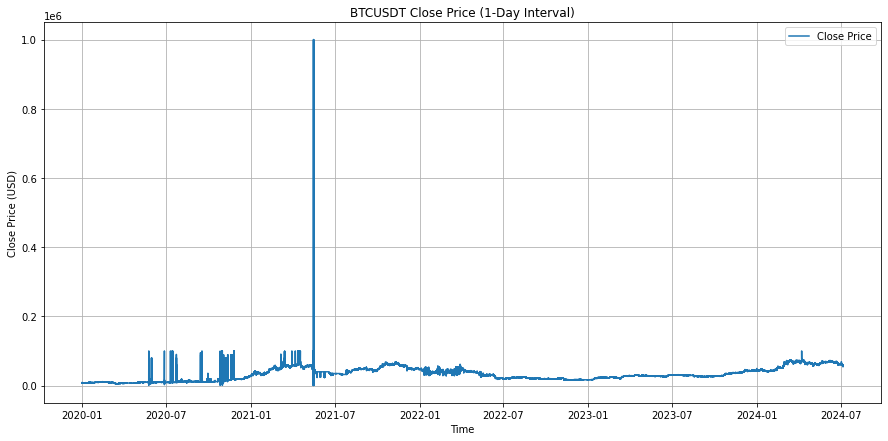

In [9]:
# Plot the 'Close' price over time
plt.figure(figsize=(15, 7))
plt.plot(BTCUSDT_Filtered_data_1M['Close'], label='Close Price')
plt.title('BTCUSDT Close Price (1-Day Interval)')
plt.xlabel('Time')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

## Now, Enough Plotting! On The Task!

## Generate Different Timeframe

### Converting 1 Minute Interval Data to 4 Hour Interval Data

In [7]:
BTCUSDT_Filtered_data_4H = convert_1m_to_any_timeframe(copy.deepcopy(BTCUSDT_Filtered_data_1M), '4H')
BTCUSDT_Filtered_data_4H

,Open,High,Low,Close,Volume
Open time (4H),,,,,
2020-01-01 00:00:00,7169.71,7207.23,7156.65,7202.48,3428.062092
2020-01-01 04:00:00,7202.48,9592.00,6871.45,7241.63,285722.475587
2020-01-01 08:00:00,7241.63,7243.46,7215.94,7223.72,3629.004242
2020-01-01 12:00:00,7223.71,7233.33,7178.00,7201.02,3491.032767
2020-01-01 16:00:00,7201.56,7236.58,7187.86,7220.85,3125.298729
...,...,...,...,...,...
2024-07-04 16:00:00,57890.00,58600.00,56666.00,57628.80,50.266283
2024-07-04 20:00:00,57628.80,59111.00,57438.20,58768.00,7.108233
2024-07-05 00:00:00,58650.70,59706.50,57000.10,58359.00,11.704692


## Performing Back Testing

### Using Signals Generated From MACD On 1 Year Data Of 4-Hour Time Interval

### Extracting 1 Year Data Of 4 Hour Interval

In [8]:
# Fetch 1 Year Data
# BTCUSDT_Filtered_data_4H_Prev_1_Year = BTCUSDT_Filtered_data_4H.loc['2023-07-02' : '2024-07-02']
BTCUSDT_Filtered_data_4H_Prev_1_Year = BTCUSDT_Filtered_data_4H.loc[:]
BTCUSDT_Filtered_data_4H_Prev_1_Year

,Open,High,Low,Close,Volume
Open time (4H),,,,,
2020-01-01 00:00:00,7169.71,7207.23,7156.65,7202.48,3428.062092
2020-01-01 04:00:00,7202.48,9592.00,6871.45,7241.63,285722.475587
2020-01-01 08:00:00,7241.63,7243.46,7215.94,7223.72,3629.004242
2020-01-01 12:00:00,7223.71,7233.33,7178.00,7201.02,3491.032767
2020-01-01 16:00:00,7201.56,7236.58,7187.86,7220.85,3125.298729
...,...,...,...,...,...
2024-07-04 16:00:00,57890.00,58600.00,56666.00,57628.80,50.266283
2024-07-04 20:00:00,57628.80,59111.00,57438.20,58768.00,7.108233
2024-07-05 00:00:00,58650.70,59706.50,57000.10,58359.00,11.704692


### Generating Signals Using MACD Indicator Function

In [9]:
# Calculate MACD for the 4-Hour data
BTCUSDT_Filtered_data_4H_Prev_1_Year_with_macd = calculate_macd(copy.deepcopy(BTCUSDT_Filtered_data_4H_Prev_1_Year))

# Generate trading signals based on MACD
BTCUSDT_Filtered_data_4H_Prev_1_Year_with_macd = generate_macd_signals(BTCUSDT_Filtered_data_4H_Prev_1_Year_with_macd)

# Print the data with MACD, Signal line, and signals
BTCUSDT_Filtered_data_4H_Prev_1_Year_with_macd = BTCUSDT_Filtered_data_4H_Prev_1_Year_with_macd[[
    'Open',
    'High',
    'Low',
    'Close',
    'Volume',
    'Signal'
]]
BTCUSDT_Filtered_data_4H_Prev_1_Year_with_macd

,Open,High,Low,Close,Volume,Signal
Open time (4H),,,,,,
2020-01-01 00:00:00,7169.71,7207.23,7156.65,7202.48,3428.062092,0
2020-01-01 04:00:00,7202.48,9592.00,6871.45,7241.63,285722.475587,1
2020-01-01 08:00:00,7241.63,7243.46,7215.94,7223.72,3629.004242,1
2020-01-01 12:00:00,7223.71,7233.33,7178.00,7201.02,3491.032767,1
2020-01-01 16:00:00,7201.56,7236.58,7187.86,7220.85,3125.298729,1
...,...,...,...,...,...,...
2024-07-04 16:00:00,57890.00,58600.00,56666.00,57628.80,50.266283,-1
2024-07-04 20:00:00,57628.80,59111.00,57438.20,58768.00,7.108233,-1
2024-07-05 00:00:00,58650.70,59706.50,57000.10,58359.00,11.704692,-1


### Extracting 1 Year Data Of 1 Minute Intervals & Generating Signals Using MACD Indicator Function

In [10]:
# Fetch 1 Year Data
BTCUSDT_Filtered_data_1M_Prev_1_Year = BTCUSDT_Filtered_data_1M.loc['2023-07-02' :]
# Calculate MACD for the 4-Hour data
BTCUSDT_Filtered_data_1M_Prev_1_Year_with_macd = calculate_macd(copy.deepcopy(BTCUSDT_Filtered_data_1M_Prev_1_Year))

# Generate trading signals based on MACD
BTCUSDT_Filtered_data_1M_Prev_1_Year_with_macd = generate_macd_signals(BTCUSDT_Filtered_data_1M_Prev_1_Year_with_macd)

# Print the data with MACD, Signal line, and signals
BTCUSDT_Filtered_data_1M_Prev_1_Year_with_macd = BTCUSDT_Filtered_data_1M_Prev_1_Year_with_macd[[
    'Open',
    'High',
    'Low',
    'Close',
    'Volume',
    'Signal'
]]
BTCUSDT_Filtered_data_1M_Prev_1_Year_with_macd

,Open,High,Low,Close,Volume,Signal
Open time (1M),,,,,,
2023-07-02 00:00:00,30598.0,30598.0,30430.1,30550.0,134.917,0
2023-07-02 00:01:00,30476.7,30598.0,30476.6,30476.6,35.196,-1
2023-07-02 00:02:00,30500.0,30598.0,30476.6,30598.0,45.206,1
2023-07-02 00:03:00,30598.0,30598.0,30519.7,30598.0,67.580,1
2023-07-02 00:04:00,30598.0,30598.0,30524.0,30598.0,45.927,1
...,...,...,...,...,...,...
2024-07-05 10:41:00,55700.0,55700.0,55397.3,55500.0,1.283,1
2024-07-05 10:42:00,55500.0,55562.4,54959.5,55500.0,4.314,1
2024-07-05 10:43:00,55500.0,55500.0,54760.0,54923.9,8.064,-1


## Backtesting Using Transaction Fees & Initial Balance (Mimicking Real Life Scenario)
### Add Profit & Subtract Loss On Initial Balance, Plus Subtract Transaction Fees From Current Balance Whenever A Transaction / Trade Is Performed
- Initial Balance: 1000
- Trasaction Fees: 0.1 Or 1%

### Applying Backtesting Algorithm

In [11]:
backtest_df = generate_backtest_df(BTCUSDT_Filtered_data_4H_Prev_1_Year_with_macd, BTCUSDT_Filtered_data_1M_Prev_1_Year)
backtest_df

,Open time (4H),direction,entry price,close price,action,PNL,Balance
0,2020-01-01 04:00:00,long,7202.48,0.00,None,NaN,9.893461e+02
1,2020-01-02 04:00:00,long,7202.48,7197.77,direction,-0.065394,9.893461e+02
2,2020-01-02 04:00:00,short,7197.77,0.00,None,NaN,9.789055e+02
3,2020-01-03 12:00:00,short,7197.77,7201.75,direction,-0.055295,9.789055e+02
4,2020-01-03 12:00:00,long,7201.75,0.00,None,NaN,1.088197e+03
...,...,...,...,...,...,...,...
1611,2024-06-27 16:00:00,short,61786.60,61415.40,direction,0.600778,-4.689898e+06
1612,2024-06-27 16:00:00,long,61415.40,0.00,None,NaN,-4.912532e+06
1613,2024-07-01 19:43:00,long,61415.40,64945.00,tp,5.747093,-4.912532e+06
1614,2024-07-03 00:00:00,short,63077.30,0.00,None,NaN,-5.110858e+06


# ***More Later!***